In [1]:
from tmu.tsetlin_machine import TMCoalescedClassifier
import numpy as np 
import pickle
import torch
import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from apriori_python import apriori
import seaborn as sns
import matplotlib.pyplot as plt
!export OMP_NUM_THREADS=10
n_clauses_per_class = 8000
treshold = int(n_clauses_per_class * 0.8)
t1 = 500
t2 = 1000
t3 = 6400
t4 = 30000

s_param_e1 = 3
s_param_e2 = 11.4
s_param_e3 = 19.8

In [2]:
game_amount = 100000
# tsetlin_filename, self_can_bet_index= "/home/jaoi/master22/pet_for_sale/winning_games_db/{}_tsetlined_games.pkl".format(game_amount), 17
tsetlin_filename, self_can_bet_index = "/home/jaoi/master22/pet_for_sale/winning_games_db/4PPO_{}_tsetlined_games.pkl".format(game_amount), 21

with open(tsetlin_filename, "rb") as fp:
        games = pickle.load(fp)

In [4]:
where_can = []
for i, game in enumerate(games):
    if game[0][self_can_bet_index] == 1:
        where_can.append(i)
indexes = np.array(where_can)

games_can_bid = games[indexes]

def remove_duplicate_pairs(games):
    new_games = []
    for i,game in enumerate(games):
        int_arr = game[0].astype(int)
        complete_arr = np.append(int_arr, game[1])
        new_games.append(complete_arr)

    new_games = np.array(new_games)
    
    x = np.random.rand(new_games.shape[1])
    y = new_games.dot(x)
    unique, index = np.unique(y, return_index=True)
    unique_xy = new_games[index]
    
    unique_pairs = []
    for game in unique_xy:
        last, rest = game[-1], game[:-1]
        unique_pairs.append(np.array((rest.astype(np.float32), last), dtype=object))
    return np.array(unique_pairs)
unique_pairs = remove_duplicate_pairs(games_can_bid)

ysu = Counter()
for game in unique_pairs:
    ysu[game[1]] += 1
    
need_of_oversample = [tup for tup in ysu.most_common() if tup[1] < 2000]

def oversample(info_tup, desired_amount, source_games):
    bob = []
    for game in source_games:
        if game[1] == info_tup[0]:
            bob.append(game)
    indexes = np.random.randint(0, info_tup[1], desired_amount - info_tup[1])
    temp = []
    for ind in indexes:
        temp.append(bob[ind])
    return np.array(temp)

unique_oversample = np.copy(unique_pairs)
temp = []
for overnd in need_of_oversample:
    temp.extend(oversample(overnd, 2000, unique_pairs))
unique_oversample = np.concatenate((unique_oversample, np.array(temp)), axis=0)

uo = Counter()
for game in unique_oversample:
    uo[game[1]] += 1

In [5]:
x =np.array([game[0] for game in unique_oversample[:, :1]])
y =np.array([game[0] for game in unique_oversample[:, 1:]])


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2)

In [7]:
cuda_e1_tm = TMCoalescedClassifier(n_clauses_per_class, t4, s_param_e1,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e2_tm = TMCoalescedClassifier(n_clauses_per_class, t4, s_param_e2,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e3_tm = TMCoalescedClassifier(n_clauses_per_class, t4, s_param_e3,  platform='CUDA', boost_true_positive_feedback=0)

In [15]:
cuda_e1_tmt3 = TMCoalescedClassifier(n_clauses_per_class, t3, s_param_e1,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e2_tmt3 = TMCoalescedClassifier(n_clauses_per_class, t3, s_param_e2,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e3_tmt3 = TMCoalescedClassifier(n_clauses_per_class, t3, s_param_e3,  platform='CUDA', boost_true_positive_feedback=0)

In [21]:
cuda_e1_tmt2 = TMCoalescedClassifier(n_clauses_per_class, t2, s_param_e1,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e2_tmt2 = TMCoalescedClassifier(n_clauses_per_class, t2, s_param_e2,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e3_tmt2 = TMCoalescedClassifier(n_clauses_per_class, t2, s_param_e3,  platform='CUDA', boost_true_positive_feedback=0)

In [24]:
cuda_e1_tmt1 = TMCoalescedClassifier(n_clauses_per_class, t1, s_param_e1,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e2_tmt1 = TMCoalescedClassifier(n_clauses_per_class, t1, s_param_e2,  platform='CUDA', boost_true_positive_feedback=0)
cuda_e3_tmt1 = TMCoalescedClassifier(n_clauses_per_class, t1, s_param_e3,  platform='CUDA', boost_true_positive_feedback=0)

In [25]:
epochs = 1
for epoch in range(epochs):
    cuda_e1_tmt1.fit(x_train, y_train)
    cuda_e2_tmt1.fit(x_train, y_train)
    cuda_e3_tmt1.fit(x_train, y_train)
    
    

    print("Epoch {} Accuracy tm1:".format(epoch), 100*(cuda_e1_tmt1.predict(x_test) == y_test).mean())
    print("Epoch {} Accuracy tm2:".format(epoch), 100*(cuda_e2_tmt1.predict(x_test) == y_test).mean())    
    print("Epoch {} Accuracy tm3:".format(epoch), 100*(cuda_e3_tmt1.predict(x_test) == y_test).mean())    

Epoch 0 Accuracy tm1: 44.8349929617851
Epoch 0 Accuracy tm2: 71.70116260883165
Epoch 0 Accuracy tm3: 74.62280381627653


In [9]:
c_out1 = cuda_e1_tm.transform(x_test[0].reshape(1, -1))
clauses_out1 = np.where(c_out1 == 1)[1].astype(int)
c_out2 = cuda_e2_tm.transform(x_test[0].reshape(1, -1))
clauses_out2 = np.where(c_out2 == 1)[1].astype(int)
c_out3 = cuda_e3_tm.transform(x_test[0].reshape(1, -1))
clauses_out3 = np.where(c_out3 == 1)[1].astype(int)

In [10]:
def prepare_tm_for_plot(x, y, tm, sigma=0):
    c_out = tm.transform(x.reshape(1, -1))
    clauses_out = np.where(c_out == 1)[1].astype(int)
    mw = tm.weight_banks[y].get_weights()
    weight_to_plot = mw[clauses_out]
    clauses_out_r = weight_to_plot[abs(weight_to_plot) > sigma]
    return clauses_out_r

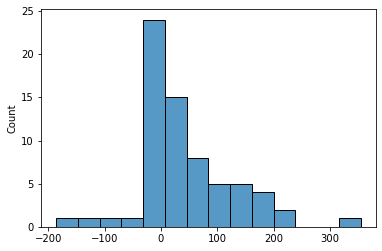

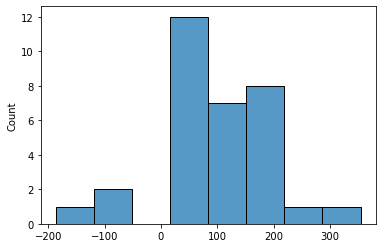

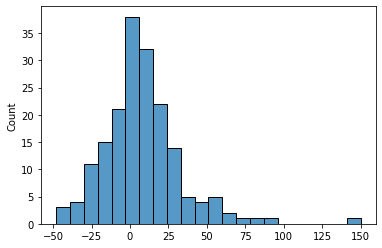

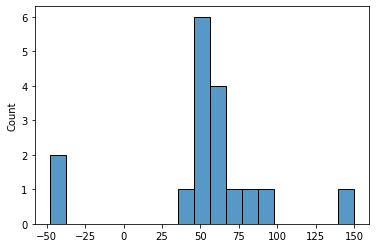

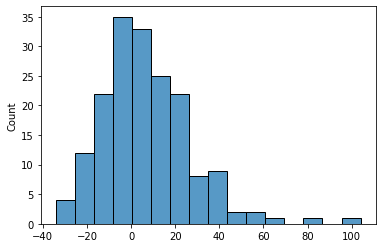

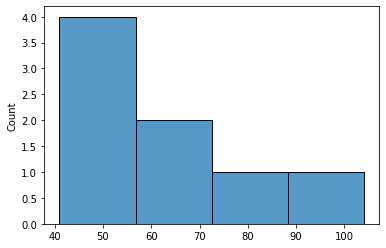

In [26]:
plot_data1 = prepare_tm_for_plot(x_test[0], y_test[0], cuda_e1_tmt1)
ax = sns.histplot(plot_data1)
file = "graphing_data/hist_T{}_S{}_{}sig.pkl".format(t1, s_param_e1, 0)
with open(file, "wb") as fp:
    pickle.dump(plot_data1, fp)
plt.show()

plot_data1 = prepare_tm_for_plot(x_test[0], y_test[0], cuda_e1_tmt1, 40)
ax = sns.histplot(plot_data1)
file = "graphing_data/hist_T{}_S{}_{}sig.pkl".format(t1, s_param_e1, 40)
with open(file, "wb") as fp:
    pickle.dump(plot_data1, fp)
plt.show()

plot_data1 = prepare_tm_for_plot(x_test[0], y_test[0], cuda_e2_tmt1)
ax = sns.histplot(plot_data1)
file = "graphing_data/hist_T{}_S{}_{}sig.pkl".format(t1, s_param_e2, 0)
with open(file, "wb") as fp:
    pickle.dump(plot_data1, fp)
plt.show()

plot_data1 = prepare_tm_for_plot(x_test[0], y_test[0], cuda_e2_tmt1, 40)
ax = sns.histplot(plot_data1)
file = "graphing_data/hist_T{}_S{}_{}sig.pkl".format(t1, s_param_e2, 40)
with open(file, "wb") as fp:
    pickle.dump(plot_data1, fp)
plt.show()

plot_data1 = prepare_tm_for_plot(x_test[0], y_test[0], cuda_e3_tmt1)
ax = sns.histplot(plot_data1)
file = "graphing_data/hist_T{}_S{}_{}sig.pkl".format(t1, s_param_e3, 0)
with open(file, "wb") as fp:
    pickle.dump(plot_data1, fp)
plt.show()
    
plot_data1 = prepare_tm_for_plot(x_test[0], y_test[0], cuda_e3_tmt1, 40)
ax = sns.histplot(plot_data1)
file = "graphing_data/hist_T{}_S{}_{}sig.pkl".format(t1, s_param_e3, 40)
with open(file, "wb") as fp:
    pickle.dump(plot_data1, fp)
plt.show()